### Prediction of Well Rate by Machine Learning Models

In [1]:
import imageio
import numpy as np
import pandas as pd 
from pathlib import Path 
import matplotlib.pyplot as plt 
from IPython.display import Image

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
def get_rmse(y_true, y_pred):
    #return np.sqrt(mean_squared_error(y_true, y_pred)) # Choice 1
    return np.sqrt(np.mean((y_pred-y_true)**2.0)) # Choice 2: equivalent to choice 1

def get_rel_l2_error(y_true, y_pred):
    return np.linalg.norm(y_true-y_pred, 2) / np.linalg.norm(y_true, 2)

### Load data about a table to predict well flow rate at the standard condition based on 3 well grid block pressure and their corresponding calculated rate through peaceman equation. 

#### Example modified from: B. Yan. et al., 2022. A physics-constrained deep learning model for simulating multiphase flow in 3D heterogeneous porous media. Fuel. URL: https://www.sciencedirect.com/science/article/pii/S001623612102559X  

Load the dataset first.

In [3]:
# Load data in csv file through pandas
dataset = pd.read_csv(f'well_data_ts.csv')

Let's start off by confirming the dimensions of the dataset, e.g. the number of rows and columns.

In [4]:
# shape 
print(f'Data shape: {dataset.shape}.')

Data shape: (1836, 11).


We have 1836 instances to work with and can confirm the data has 10 attributes including:

(1) 'sample': Sample number of each time series data;

(2) 'days': time steps;

(3) 'ratio': the output attribute;

(4) 'pres#' (# = 1, 2, 3): 3 different well grid pressure $p_i$ (originally predicted by a customized UNet in the reference paper);

(5) 'rate#' (# = 1, 2, 3): 3 different calculated well influx $q_i$ based on peaceman equation, at reservoir condition (originally calculated by 'pres#' through peaceman equation in the reference paper);

(6) 'qProd': well rate at standard condition;

(7) 'ratio': qProd / sum(rate#)

(8) 'category': 'train' or 'test' data category.

We will need to build a model to use 'pres#' to predict 'ratio', and then use 'ratio' and 'rate#' to get 'qProd'.

For attribute 'rate#', it is calculated by peaceman well model (a physics model),

$$
q_i = WI_i \frac{\rho}{\mu}(p_i - p_w)
$$

where $q_i$ is well rate at each perforation $i$, reservoir barrel/day; $WI$ is the well index based on peaceman well model; $\rho$ is fluid density, $lb/ft^3$; $p_w$ is the well pressure, psia; $p$ is the well grid block pressure at each grid $i$ ($i=1, 2, 3$).

The 'ratio' column is calculated by $\frac{q_s}{\sum q_i}$, where $q_s$ is the total flow rate in the standard condition, standard barrel/day.

We can see that all of the attributes are numeric and in real values.

In [5]:
# types
print(f'{dataset.dtypes}.')

sample        int64
days          int64
pres1       float64
pres2       float64
pres3       float64
rate1       float64
rate2       float64
rate3       float64
qProd       float64
ratio       float64
category     object
dtype: object.


Let's now take a peek at the first 20 rows of the data.

In [6]:
# Check data 
# Validate the calculation of rate in dataset
# dataset['ratio1'] = dataset['qProd'] / (dataset['rate1'] + dataset['rate2'] + dataset['rate3'])
dataset.head(20)

,sample,days,pres1,pres2,pres3,rate1,rate2,rate3,qProd,ratio,category
0,0,31,3526.5,3531.4,3536.2,84.152388,537.791330,1824.649155,2.4111,0.000985,train
1,0,60,3534.9,3539.8,3544.6,555.405760,1243.642450,3193.136021,15.7480,0.003155,train
2,0,91,3539.7,3544.6,3549.4,824.693401,1646.985948,3975.128516,23.3710,0.003625,train
3,0,121,3543.0,3547.8,3552.6,1009.828654,1915.881613,4496.456846,28.5060,0.003841,train
4,0,152,3546.7,3551.5,3556.3,1217.404544,2226.792225,5099.242727,34.3480,0.004020,train
5,0,182,3549.8,3554.7,3559.5,1391.319479,2495.687890,5620.571057,39.3630,0.004140,train
6,0,213,3552.1,3556.9,3561.7,1520.353140,2680.553660,5978.984284,42.9520,0.004219,train
7,0,244,3554.0,3558.8,3563.6,1626.946165,2840.210461,6288.522980,45.9480,0.004272,train
8,0,274,3555.3,3560.2,3564.9,1699.878235,2957.852314,6500.312614,48.0840,0.004309,train
9,0,305,3556.9,3561.8,3566.5,1789.640782,3092.300147,6760.976779,50.6410,0.004350,train


Let's summarize the distribution of each attribute.

In [7]:
# descriptions
pd.set_option('precision', 1)
print(dataset.describe())

       sample    days   pres1   pres2   pres3    rate1     rate2    rate3  \
count  1836.0  1836.0  1836.0  1836.0  1836.0   1836.0    1836.0   1836.0   
mean     13.0  1049.8  3600.8  3609.9  3618.9   7637.0   24922.3  23774.2   
std       7.8   597.5    48.7    46.4    44.4   8056.2   30768.8  13932.7   
min       0.0    31.0  3524.2  3529.1  3533.9      0.0       0.0      0.0   
25%       6.0   539.5  3563.2  3573.0  3584.3   2012.2    4018.7  13036.3   
50%      13.0  1050.0  3593.6  3604.6  3613.8   4250.4    9092.4  20063.0   
75%      20.0  1559.5  3627.9  3635.7  3645.6  10380.0   37444.5  33352.3   
max      26.0  2070.0  3749.0  3753.8  3757.9  35234.7  121296.3  64017.6   

        qProd    ratio  
count  1836.0  1.8e+03  
mean    234.1  4.2e-03  
std     221.8  9.8e-04  
min       0.0  0.0e+00  
25%      85.2  3.9e-03  
50%     153.0  4.5e-03  
75%     295.5  4.9e-03  
max    1008.4  5.1e-03  


In [8]:
# Choose the columns with physical meaning for visualization
choosed_columns = ['days', 'pres1', 'pres2', 'pres3', 'rate1', 'rate2', 'rate3', 'qProd', 'ratio']

Now, let's now take a look at the correlation between all of the numeric attributes.

In [9]:
# correlation
pd.set_option('precision', 2)
print(dataset[choosed_columns].corr(method='pearson'))

       days  pres1  pres2  pres3  rate1  rate2  rate3  qProd  ratio
days   1.00   0.41   0.43   0.45   0.22   0.15   0.31   0.25   0.25
pres1  0.41   1.00   1.00   0.98   0.10  -0.12   0.20   0.14   0.74
pres2  0.43   1.00   1.00   1.00   0.16  -0.05   0.28   0.21   0.71
pres3  0.45   0.98   1.00   1.00   0.23   0.03   0.36   0.27   0.67
rate1  0.22   0.10   0.16   0.23   1.00   0.96   0.89   0.99   0.10
rate2  0.15  -0.12  -0.05   0.03   0.96   1.00   0.85   0.96  -0.08
rate3  0.31   0.20   0.28   0.36   0.89   0.85   1.00   0.93   0.04
qProd  0.25   0.14   0.21   0.27   0.99   0.96   0.93   1.00   0.13
ratio  0.25   0.74   0.71   0.67   0.10  -0.08   0.04   0.13   1.00


Let's look at visualizations of individual attributes. It is often useful to look at your data using multiple different visualizations in order to spark ideas. Let's look at histograms of each attribute to get a sense of the data distributions.

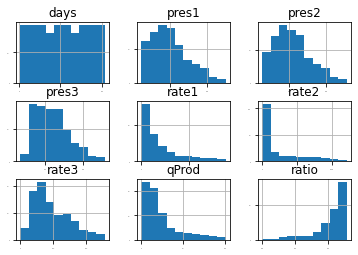

In [10]:
# histograms
dataset[choosed_columns].hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1)
plt.show()

Let's look at the same distributions using density plots that smooth them out a bit.

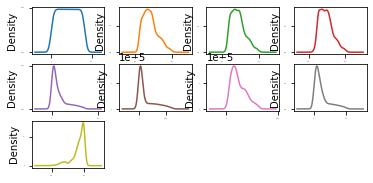

In [11]:
# density
dataset[choosed_columns].plot(kind='density', subplots=True, layout=(4,4), sharex=False, legend=False, fontsize=1)
plt.show()

Let's look at the data with box and whisker plots of each attribute. This helps point out the skew in many distributions so much so that data looks like outliers (e.g. beyond the whisker of the plots).

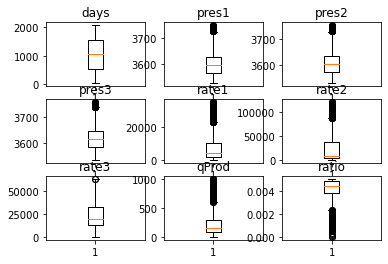

In [12]:
# box and whisker plots
# dataset.plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False, fontsize=8) # not quite pretty
for i, col in enumerate(choosed_columns, 1):
    plt.subplot(3, 3, i)
    plt.boxplot(dataset[col])
    plt.title(col)
plt.show()

Let's also visualize the correlations between the attributes.

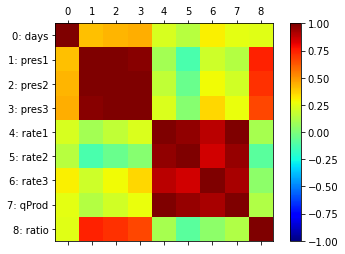

In [13]:
names = [f'{i}: {s}' for i, s in enumerate(choosed_columns)]

# correlation matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(dataset[choosed_columns].corr(), vmin=-1, vmax=1, interpolation='none', cmap='jet')
fig.colorbar(cax)
ticks = np.arange(0,9,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_yticklabels(names)
plt.show()

Plot the time series data.

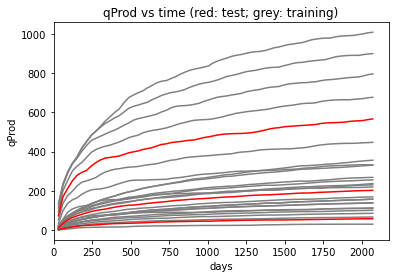

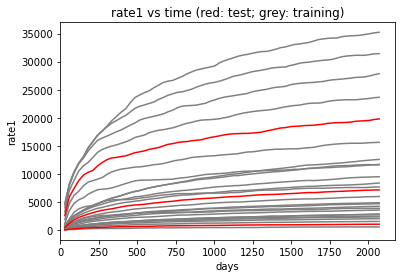

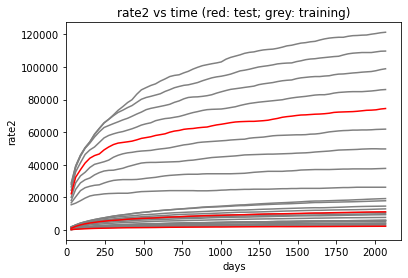

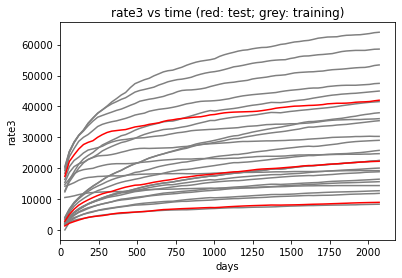

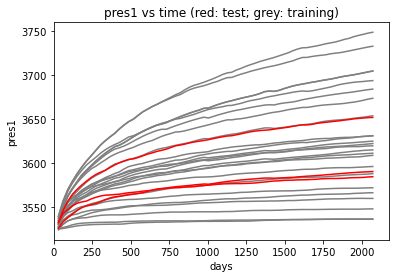

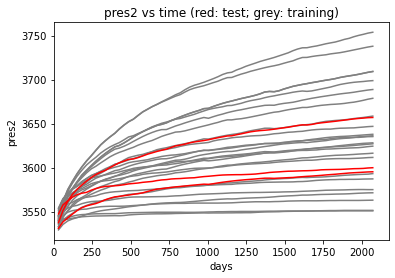

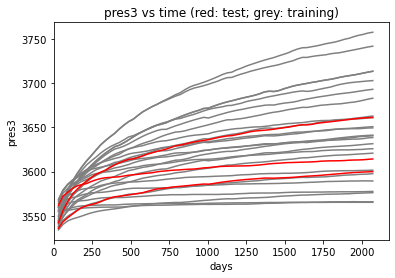

In [14]:
def plot_ts(dataset, plot_col):
    
    samples = dataset['sample'].unique()

    colors = {'train': 'grey', 'test': 'red'}
    for cat in ['train', 'test']:
        for isample in samples:
            df = dataset[dataset['sample'] == isample]
            dcat = df['category'].values[0]
            if dcat == cat:
                plt.plot(df['days'], df[plot_col], color=colors[dcat])
            
    plt.xlim(xmin=0)
    plt.xlabel('days')
    plt.ylabel(plot_col)
    plt.title(f'{plot_col} vs time (red: test; grey: training)')
    plt.show()

# Plot qProd data
plot_ts(dataset, plot_col='qProd')
plot_ts(dataset, plot_col='rate1')
plot_ts(dataset, plot_col='rate2')
plot_ts(dataset, plot_col='rate3')
plot_ts(dataset, plot_col='pres1')
plot_ts(dataset, plot_col='pres2')
plot_ts(dataset, plot_col='pres3')

The dark red color shows positive correlation whereas the dark blue color shows negative correlation. Here basically all variables are positively correlated.

### Train Model and Tune Parameters

It is a good idea to use a validation hold-out set. This is a sample of the data that we hold back from our analysis and modeling. We use it right at the end of our project to confirm the accuracy of our final model. It is a smoke test that we can use to see if we messed up and to give us confidence on our estimates of accuracy on unseen data. We will use 80% of the dataset for modeling and hold back 20% for validation.

Since we know the physical meaning the each attributes, and we know that as the ratio $\frac{q_s}{\sum q_i}$ is strongly related to the pressure at each well grid plot, we can directly develop models to predict it.

Split the original dataset into train and test sub-dataframes.

In [15]:
dataset_train = dataset.loc[dataset['category']=='train']
dataset_test = dataset.loc[dataset['category']=='test']

Define the input and output columns for machine learning model.

In [16]:
feature_cols = ['pres1', 'pres2', 'pres3']
label_col = ['ratio']

Get input and output data and scale them.

In [17]:
# Only take the training data to build the model first
X_train = dataset_train[feature_cols].values
Y_train = dataset_train[label_col].values

Creat scaler for both input X and output Y based on training data.

In [18]:
# Define scalers based on MinMax, but you can also try Standard Scaler
input_scaler = MinMaxScaler().fit(X_train)
output_scaler = MinMaxScaler().fit(Y_train)

# Transform data
X_train_scaled = input_scaler.transform(X_train)
Y_train_scaled = output_scaler.transform(Y_train)

# Flatten Y to avoid warning in fit models
Y_train_scaled = Y_train_scaled.flatten()

Evaluate Algorithms: Baseline

We have no idea what algorithms will do well on this problem. Gut feel suggests regression algorithms like Linear Regression may do well. It is also possible that even SVM may do well. I have no idea. Let's design our test harness. We will use 10-fold cross-validation. The dataset is not too small and this is a good standard test harness configuration. We will evaluate algorithms using the Mean Squared Error (MSE) metric. MSE will give a gross idea of how wrong all predictions are (0 is perfect).

In [31]:
# Test options and evaluation metric
num_folds = 10 # Split the dataset into 10 folds(parts), train model on 9 folds and hold 1 fold for cross validation
seed = 7
scoring = 'neg_root_mean_squared_error' # Root Mean Squared Error

Let's create a baseline of performance on this problem and spot-check a number of different algorithms. We will select a suite of different algorithms capable of working on this regression problem. The four algorithms selected include:

(1) Linear Algorithms: Linear Regression (LR). 

(2) Nonlinear Algorithms: RandomForestRegressor (RF), Gradient Boosting Regressor (GBM) and, Support Vector Regression (SVR).

Linear Regression fits a linear model with coefficients w = (w1, …, wp) to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation. Default: fit_intercept=True.

Random Forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. Default: n_estimators = 100, the number of trees in the forest; max_depth: int, default=None, the maximum depth of the tree; min_samples_split: int, default=2, the minimum number of samples required to split an interval node.

Gradient Boosting builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions. In each stage a regression tree is fit on the negative gradient of the given loss function. Default: n_estimators: int, default=100, The number of boosting stages to perform. Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.

Support Vector Regression is a supervised learning algorithm that is used to predict discrete values. Support Vector Regression uses the same principle as the SVMs. The basic idea behind SVR is to find the best fit line. In SVR, the best fit line is the hyperplane that has the maximum number of points.

The algorithms all use default tuning parameters. Let's compare the algorithms. We will display the mean and standard deviation of MSE for each algorithm as we calculate it and collect the results for use later.

In [35]:
# Spot-Check Algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('RF', RandomForestRegressor())) 
models.append(('GBM', GradientBoostingRegressor()))
models.append(('SVR', SVR()))

The algorithms all use default tuning parameters. Let's compare the algorithms. We will display the mean and standard deviation of RMSE for each algorithm as we calculate it and collect the results for use later.

In [36]:
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train_scaled, Y_train_scaled, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: -0.108740 (0.009103)
RF: -0.022005 (0.003421)
GBM: -0.027833 (0.002834)
SVR: -0.065760 (0.003212)


Let's take a look at the distribution of scores across all cross-validation folds by algorithm.

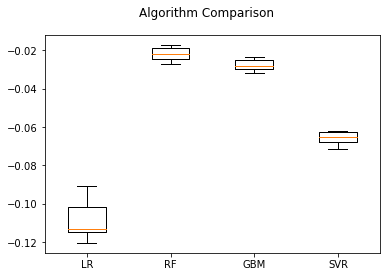

In [37]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Tune GradientBoostingRegressor as an exmple.

The default number of boosting stages to perform (n estimators) is 100. This is a good candidate parameter of Gradient Boosting to tune. Often, the larger the number of boosting stages, the better the performance but the longer the training time.

In [38]:
param_grid = {
    'n_estimators': np.array([50,100,150,200,250,300,350,400])
}

In [39]:
param_grid

{'n_estimators': array([ 50, 100, 150, 200, 250, 300, 350, 400])}

In [41]:
# Grid search is an approach to parameter tuning that will methodically build and evaluate a model
# - for each combination of algorithm parameters specified in a grid. You can perform a grid search 
# - using the GridSearchCV class.

model = GradientBoostingRegressor(random_state=seed)
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train_scaled, Y_train_scaled)

In [42]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.026039 using {'n_estimators': 400}
-0.032564 (0.002989) with: {'n_estimators': 50}
-0.027838 (0.002827) with: {'n_estimators': 100}
-0.027065 (0.002720) with: {'n_estimators': 150}
-0.026778 (0.002601) with: {'n_estimators': 200}
-0.026514 (0.002563) with: {'n_estimators': 250}
-0.026297 (0.002577) with: {'n_estimators': 300}
-0.026142 (0.002481) with: {'n_estimators': 350}
-0.026039 (0.002541) with: {'n_estimators': 400}


We can see that the best configuration was n estimators=400 resulting in a root mean squared error of -0.026039.

#### Finalize the Model

In this section we will finalize the gradient boosting model and evaluate it on our hold out validation dataset.

Scale the test data based on the scalers already fit training data.

In [44]:
X_test = dataset_test[feature_cols].values
ratio_test = dataset_test[label_col].values

X_test_scaled = input_scaler.transform(X_test)
ratio_test_scaled = output_scaler.transform(ratio_test)
ratio_test_scaled = ratio_test_scaled.flatten()

In [45]:
# prepare the gbm model
gbm_model = GradientBoostingRegressor(random_state=seed, n_estimators=400)

# Fit the model 
gbm_model.fit(X_train_scaled, Y_train_scaled)

# Predict the validation data set 
ratio_test_scaled_pred_by_gbm = gbm_model.predict(X_test_scaled).reshape(-1, 1)

# Inversely transform the validation dataset back
ratio_test_pred_by_gbm = output_scaler.inverse_transform(ratio_test_scaled_pred_by_gbm)

In [46]:
# prepare the linear model
linear_model = LinearRegression()

# Fit the model 
linear_model.fit(X_train_scaled, Y_train_scaled)

# Predict the validation data set 
ratio_test_scaled_pred_by_lr = linear_model.predict(X_test_scaled).reshape(-1, 1)

# Inversely transform the validation dataset back
ratio_test_pred_by_lr = output_scaler.inverse_transform(ratio_test_scaled_pred_by_lr)

In [47]:
score_rmse_by_gbm = get_rmse(ratio_test, ratio_test_pred_by_gbm)
score_rmse_by_lr = get_rmse(ratio_test, ratio_test_pred_by_lr)

print(f'RMSE of test ratio predicted by Gradient boost is {score_rmse_by_gbm: .3e}.')
print(f'RMSE of test ratio predicted by linear regression is {score_rmse_by_lr: .3e}.')

RMSE of test ratio predicted by Gradient boost is  7.685e-05.
RMSE of test ratio predicted by linear regression is  4.167e-04.


Back calculate qProd based on rate# and the predicted ratio

In [48]:
qProd_pred_gbm = (dataset_test['rate1'] + dataset_test['rate2'] + dataset_test['rate3']) * ratio_test_pred_by_gbm.reshape(-1)
qProd_pred_lr = (dataset_test['rate1'] + dataset_test['rate2'] + dataset_test['rate3']) * ratio_test_pred_by_lr.reshape(-1)

Save qProd_pred back to dataset_test

In [49]:
dataset_test.insert(9, column='qProd_pred_gbm', value=qProd_pred_gbm, allow_duplicates=False)
dataset_test.insert(9, column='qProd_pred_lr', value=qProd_pred_lr, allow_duplicates=False)

Both qProd_pred and qProd columns as saved into dataframe dataset_test.

In [50]:
dataset_test.head(10)

,sample,days,pres1,pres2,pres3,rate1,rate2,rate3,qProd,qProd_pred_lr,qProd_pred_gbm,ratio,category
340,5,31,3532.5,3537.4,3542.2,420.76,1041.97,2802.14,11.92,16.41,11.31,2.80e-03,test
341,5,60,3546.1,3551.0,3555.7,1183.74,2184.78,5001.49,33.45,33.87,33.63,4.00e-03,test
342,5,91,3556.7,3561.5,3566.3,1778.42,3067.09,6728.39,50.23,46.50,49.87,4.34e-03,test
343,5,121,3564.6,3569.4,3574.2,2221.62,3730.93,8015.42,62.78,57.16,62.74,4.49e-03,test
344,5,152,3570.4,3575.3,3580.0,2547.01,4226.70,8960.33,72.01,67.28,71.56,4.58e-03,test
345,5,182,3575.2,3580.1,3584.8,2816.30,4630.05,9742.32,79.66,74.28,78.92,4.63e-03,test
346,5,213,3579.7,3584.6,3589.3,3068.76,5008.18,10475.44,86.80,80.96,85.85,4.68e-03,test
347,5,244,3583.9,3588.7,3593.4,3304.38,5352.70,11143.39,93.38,86.01,93.27,4.72e-03,test
348,5,274,3587.3,3592.1,3596.8,3495.13,5638.41,11697.30,98.74,91.15,98.49,4.74e-03,test
349,5,305,3589.9,3594.7,3599.4,3640.99,5856.88,12120.88,102.88,95.13,101.35,4.76e-03,test


Plot the each sample in dataset_test and make a comparison between qProd_pred and qProd in dataset_test.

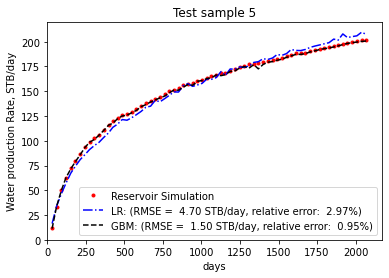

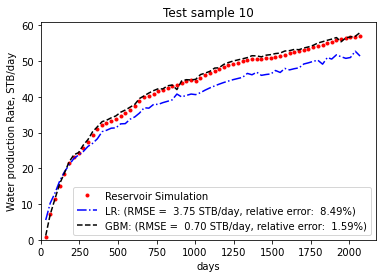

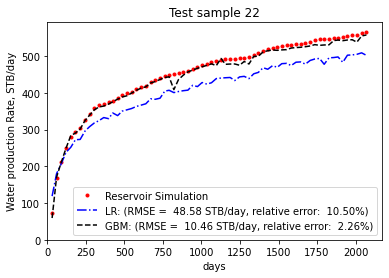

In [52]:
test_samples = dataset_test['sample'].unique()

for isample in test_samples:
    
    df = dataset_test[dataset_test['sample'] == isample]
    
    rmse_lr = get_rmse(df['qProd'], df['qProd_pred_lr'])   
    rmse_gbm = get_rmse(df['qProd'], df['qProd_pred_gbm'])   
    l2_lr = get_rel_l2_error(df['qProd'], df['qProd_pred_lr']) * 100
    l2_gbm = get_rel_l2_error(df['qProd'], df['qProd_pred_gbm']) * 100   
    
    plt.plot(df['days'], df['qProd'], 'r.', label='Reservoir Simulation')
    plt.plot(df['days'], df['qProd_pred_lr'], 'b-.', 
             label=f'LR: (RMSE = {rmse_lr: .2f} STB/day, relative error: {l2_lr: .2f}%)')
    plt.plot(df['days'], df['qProd_pred_gbm'], 'k--', 
             label=f'GBM: (RMSE = {rmse_gbm: .2f} STB/day, relative error: {l2_gbm: .2f}%)')
        
    plt.xlim(xmin=0)
    plt.ylim(ymin=0)
    plt.xlabel('days')
    plt.ylabel('Water production Rate, STB/day')
    plt.title(f'Test sample {isample}')
    plt.legend()
    plt.show()            

Save your model using pickle

In [53]:
from pickle import dump, load

In [54]:
# save the model to disk
filename = 'finalized_gbm_model.sav'
dump(gbm_model, open(filename, 'wb'))

In [55]:
# load the model from disk sometime later ...
loaded_model = load(open(filename, 'rb'))

# Predict the validation data set 
ratio_test_scaled_pred_by_gbm =  loaded_model.predict(X_test_scaled).reshape(-1, 1)

# Inversely transform the validation dataset back
ratio_test_pred_by_gbm = output_scaler.inverse_transform(ratio_test_scaled_pred_by_gbm)

score_rmse_by_gbm = get_rmse(ratio_test, ratio_test_pred_by_gbm)
print(f'RMSE of test ratio predicted by Gradient boost is {score_rmse_by_gbm: .3e}.')

RMSE of test ratio predicted by Gradient boost is  7.685e-05.
